# Excercise 1 Context

1. Sketch a contextsensitive Application

Automatic recommendations for posture adjustments depending on context (Sitting, Standing, Walking)

2. Categorize it according to Schilit (explain why)

Automatic Contextual Reconfiguration: trigger is automatic and information is provided

3. Categorize all relevant context regarding category of context, passive/active and primary/secondary

Active: sensor data (motion)
Passive: Smartphone OS

Primary: features based on sensor data
Secondary: Class-Labels and Reasoning

4. Modify a. to be in another class according to Schilit (Tip: You may modify the previous answer if this does not work)

Change room temperature based on movement (Sitting / Walking / Standing)

# Excercise 2 Sensors

WebApp

# Excercise 3 Calculating features

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from influxdb import InfluxDBClient, DataFrameClient

## 3.1 Load Data

In [2]:
# all data in browser database
influxClient = DataFrameClient(host='css20.dmz.teco.edu', port=80, database='browser',username="user", password="pass")
data = influxClient.query("select * FROM devicemotion")["devicemotion"]

In [3]:
# own recorded data
influxClient = DataFrameClient(host='css20.dmz.teco.edu', port=80, database='motion_data',username="user", password="pass")
own_data = influxClient.query("select * FROM devicemotion")["devicemotion"]

In [4]:
data.columns

Index(['acceleration.x', 'acceleration.y', 'acceleration.z',
       'accelerationIncludingGravity.x', 'accelerationIncludingGravity.y',
       'accelerationIncludingGravity.z', 'label', 'mobile',
       'rotationRate.alpha', 'rotationRate.beta', 'rotationRate.gamma',
       'subject', 'useragent'],
      dtype='object')

In [5]:
data.head(2)

,acceleration.x,acceleration.y,acceleration.z,accelerationIncludingGravity.x,accelerationIncludingGravity.y,accelerationIncludingGravity.z,label,mobile,rotationRate.alpha,rotationRate.beta,rotationRate.gamma,subject,useragent
2020-05-18 15:38:31.330200+00:00,0.0514,-0.4303,1.4837,0.038307,5.439626,9.825804,testing,UnknownPhone,-13.115,-43.004999,0.488,10b5c,Mozilla/5.0 (Linux; Android 7.0; FRD-L19) Appl...
2020-05-18 15:38:31.348400+00:00,0.6009,-0.1249,1.0312,0.172383,5.477933,9.174581,testing,UnknownPhone,-2.623,-6.527000,-2.379,10b5c,Mozilla/5.0 (Linux; Android 7.0; FRD-L19) Appl...


In [6]:
data.shape

(348025, 13)

In [7]:
# Select time window
data = data.loc['2020-05-01':'2020-10-07'].dropna()
data.shape

(346231, 13)

## 3.2 Preprocessing (Windowing / Aggregation)

In [8]:
def minmax(data):
    return np.max(data)-np.min(data)

def transform_data(data, labels, subjects):
    ### 3-Step Transformation:
    # 1. Grouping using Labels & Subjects
    # 2. Aggregation using resample with 1s as time resolution
    # 3. Transform data back to pandas dataframe
    
    ### 1. Group data according to labels and subjects
    grouped_data = {}
    for subject in subjects:
        grouped_data[subject] = {}
        subject_data = data[data['subject'] == subject]
        for label in labels:
            grouped_data[subject][label] = subject_data[subject_data["label"] == label]
    
    print("1. Grouping finished")
    ### 2. Aggregation using resample
    # Prepare aggregation
    numeric_columns = {}
    for col, dtype in zip(data.columns, data.dtypes):
        if dtype == 'float64':
            numeric_columns[col] = ['max', 'mean', 'min',"std", "var",minmax]
    
    # start aggregation
    aggregatedDict = {}
    for subject in subjects:
        aggregatedDict[subject] = {}
        for label in labels:
            # check if part is empty
            if(not grouped_data[subject][label].empty):
                # use resample for frequency conversion 
                aggregatedDict[subject][label] = grouped_data[subject][label].resample('1s').agg(numeric_columns).dropna()
    
    print("2. Aggregation finished")
    ### 3. Transform data into ungrouped and flat table
    data = pd.DataFrame()
    for subject in subjects:
        for label in labels:
            if label in aggregatedDict[subject]:
                curr_data = aggregatedDict[subject][label]
                # add label
                curr_data["label"] = len(curr_data)*[label]
                # add subject / group
                curr_data["group"] = len(curr_data)*[subject]
                data = data.append(curr_data)
    print("3. Dataframe conversion finished")
    return data

In [9]:
# Extract labels and subjects
labels = data['label'].unique()[1:] # drop "testing"-label
subjects = data['subject'].unique()
# Apply transformation
data = transform_data(data.copy(), labels, subjects)

1. Grouping finished
2. Aggregation finished
3. Dataframe conversion finished


In [10]:
len(data)

3826

## 3.3 Robust Outlier-Cleansing

In [11]:
# RMSE 3D_acceleration
minmax_3d_acc = np.sqrt(data["acceleration.x"]["minmax"]**2 + data["acceleration.y"]["minmax"]**2
                        + data["acceleration.z"]["minmax"]**2)

In [12]:
# Calculate Quantiles
Q1 = np.percentile(minmax_3d_acc, 25)  
Q3 = np.percentile(minmax_3d_acc, 75) 
# Calculate IQR
IQR = Q3 - Q1 
# Calculate bounds
low_lim = np.array(Q1 - 3 * IQR)
up_lim = np.array(Q3 + 3 * IQR)
# Get index of outliers
index = np.logical_and(minmax_3d_acc.values >= low_lim, minmax_3d_acc.values <= up_lim)

In [13]:
# Remove outliers
data = data.loc[index]

# 3.4 Visualization of recorded data



In [14]:
own_data

,acceleration.x,acceleration.y,acceleration.z,accelerationIncludingGravity.x,accelerationIncludingGravity.y,accelerationIncludingGravity.z,label,mobile,rotationRate.alpha,rotationRate.beta,rotationRate.gamma,subject,useragent
2020-10-04 08:07:37.441600+00:00,-0.200000,0.200000,0.200000,-2.200000,8.600000,4.700000,testing,Samsung,-15.20000,-17.300000,6.000000,1b6cc,Mozilla/5.0 (Linux; Android 9; SM-G950F) Apple...
2020-10-04 08:07:37.463000+00:00,-0.100000,0.200000,0.100000,-2.100000,8.600000,4.700000,testing,Samsung,-9.80000,-18.900000,7.400000,1b6cc,Mozilla/5.0 (Linux; Android 9; SM-G950F) Apple...
2020-10-04 08:07:37.478000+00:00,0.200000,0.000000,0.100000,-1.800000,8.400000,4.700000,testing,Samsung,-5.30000,-5.000000,8.100000,1b6cc,Mozilla/5.0 (Linux; Android 9; SM-G950F) Apple...
2020-10-04 08:07:37.490100+00:00,0.400000,-0.200000,0.200000,-1.500000,8.200000,4.900000,testing,Samsung,-5.50000,-6.000000,8.000000,1b6cc,Mozilla/5.0 (Linux; Android 9; SM-G950F) Apple...
2020-10-04 08:07:37.507300+00:00,0.400000,-0.100000,0.000000,-1.500000,8.300000,4.700000,testing,Samsung,-4.20000,-6.400000,3.800000,1b6cc,Mozilla/5.0 (Linux; Android 9; SM-G950F) Apple...
2020-10-04 08:07:37.523100+00:00,0.400000,0.000000,0.100000,-1.500000,8.400000,4.800000,testing,Samsung,-2.30000,-0.900000,2.000000,1b6cc,Mozilla/5.0 (Linux; Android 9; SM-G950F) Apple...
2020-10-04 08:07:37.539500+00:00,0.100000,0.100000,0.000000,-1.800000,8.500000,4.700000,testing,Samsung,0.50000,-0.200000,-0.800000,1b6cc,Mozilla/5.0 (Linux; Android 9; SM-G950F) Apple...
2020-10-04 08:07:37.563000+00:00,0.000000,0.100000,0.000000,-2.000000,8.500000,4.700000,testing,Samsung,1.50000,-0.100000,-1.400000,1b6cc,Mozilla/5.0 (Linux; Android 9; SM-G950F) Apple...
2020-10-04 08:07:37.572900+00:00,-0.200000,0.100000,0.000000,-2.000000,8.500000,4.700000,testing,Samsung,1.20000,0.200000,-1.100000,1b6cc,Mozilla/5.0 (Linux; Android 9; SM-G950F) Apple...
2020-10-04 08:07:37.587500+00:00,-0.100000,0.100000,0.000000,-2.000000,8.500000,4.700000,testing,Samsung,0.40000,1.400000,-0.700000,1b6cc,Mozilla/5.0 (Linux; Android 9; SM-G950F) Apple...


In [15]:
# Extract labels and subjects
own_labels = own_data['label'].unique()[1:] # drop "testing"-label
subjects = ["wenzlf", "flxsbr"] #EbiDa own_data['subject'].unique()
# Apply transformation
own_data = transform_data(own_data, own_labels, subjects)

1. Grouping finished
2. Aggregation finished
3. Dataframe conversion finished


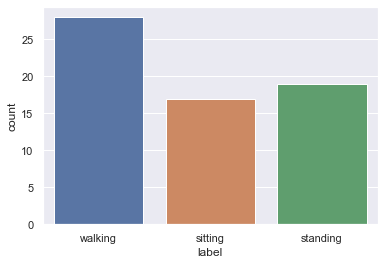

In [16]:
sns.set(style="darkgrid")
ax = sns.countplot(x="label", data=own_data)

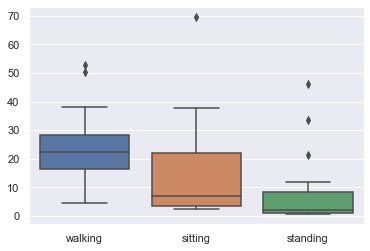

In [17]:
x = own_data["label"].values
y= np.array([(own_data["acceleration." + direction]["minmax"].values) for direction in ["x","y","z"]]).sum(axis=0)
# Box-Plot
sns.set_style("darkgrid")
box_plot = sns.boxplot(x=x,y=y)

# Excercise 4 Creating a predictor

In [18]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.feature_selection import RFE

## 4.1 Train-Test Split

In [19]:
# Seed
np.random.seed(2020)

# initialize subjects
subjects = data["group"].unique()

# Draw random Training-Data-Indices
number_subjects = len(subjects)
size = int(0.8*number_subjects)

# Extract Train/Test-Subjects
train_subjects = np.random.choice(subjects, size=size, replace=False)
test_subjects = list(set(subjects)-set(train_subjects))

# Setup train and test data
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for train_subject in train_subjects:
    train_data= train_data.append(data.loc[data["group"] == train_subject])
    
for test_subject in test_subjects:
    test_data= test_data.append(data.loc[data["group"] == test_subject])
    
# finalize train / test data
x_train = train_data.drop(["group", "label"], axis="columns")
x_test = test_data.drop(["group", "label"], axis="columns")
y_train = train_data["label"]
y_test = test_data["label"]

## 4.2 10-Fold-CV

In [20]:
# Seed
np.random.seed(1010)

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, early_stopping = True, random_state=42)
mlp_res = cross_validate(mlp, x_train, y_train, n_jobs=-1, cv=10,
                         return_estimator=False, return_train_score=True)

# RF
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_res = cross_validate(rf, x_train, y_train, n_jobs=-1, cv=10,
                         return_estimator=False, return_train_score=True)

print("MLP 10-Fold-CV-Accuracy: ", mlp_res["test_score"].mean())
print("Random Forest 10-Fold-CV-Accuracy: ", rf_res["test_score"].mean())

MLP 10-Fold-CV-Accuracy:  0.6962552370192535
Random Forest 10-Fold-CV-Accuracy:  0.7510732947323826


## 4.3 Leave-One-Subject-Out-CV

In [21]:
# Seed
np.random.seed(1111)

logo = LeaveOneGroupOut()
logo.get_n_splits(groups=train_data["group"].values)

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=100, early_stopping = True, random_state=42)
mlp_res = cross_validate(mlp, x_train, y_train, cv=logo, n_jobs=-1, groups = train_data["group"].values,
                         return_estimator=False, return_train_score=True)

# RF
rf = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
rf_res = cross_validate(rf, x_train, y_train, cv=logo, n_jobs=-1, groups = train_data["group"].values,
                        return_estimator=False, return_train_score=True)

print("MLP LOGO-CV-Accuracy: ", mlp_res["test_score"].mean())
print("Random Forest LOGO-CV-Accuracy: ", rf_res["test_score"].mean())

MLP LOGO-CV-Accuracy:  0.7085044487262049
Random Forest LOGO-CV-Accuracy:  0.7594145289611369


## 4.4 Recursive Feature Elimination

In [22]:
# Seed
np.random.seed(1212)

rfe = RFE(rf, n_features_to_select=10, step=1, verbose=0)
rfe.fit(x_train,y_train)

# evaluate
selected_features = x_train.columns[rfe.support_]
x_train_new = x_train[selected_features]

rf_res_new = cross_validate(rf, x_train_new, y_train, n_jobs=2, cv=logo, groups = train_data["group"].values,
                         return_estimator=False, return_train_score=True)
print("Random Forest - RFE -  LOGO-CV-Accuracy: ", rf_res_new["test_score"].mean())

Random Forest - RFE -  LOGO-CV-Accuracy:  0.7653243356170701


## 4.5 Classifier with Bayes-Optimization

In [23]:
# set budget for Optimization
max_iters = 10

### 4.5.1. MLP

In [44]:
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
# set seeds
np.random.seed(4321)

# define space
mlp_space = {'hidden_layer_sizes' : hp.quniform('hidden_layer_sizes',5,50,1),
             'max_iter' : hp.quniform("max_iter",10,100,1)}

def mlp_opt(params):
    from sklearn.model_selection import LeaveOneGroupOut
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import cross_validate
    
    logo = LeaveOneGroupOut()
    logo.get_n_splits(groups=train_data["group"].values)
    
    params["hidden_layer_sizes"] = int(params["hidden_layer_sizes"])
    params["max_iter"] = int(params["max_iter"])
    
    mlp = MLPClassifier(hidden_layer_sizes= params["hidden_layer_sizes"], max_iter= params["max_iter"], random_state=42)
    mlp = cross_validate(mlp, x_train_new, y_train, cv=logo, n_jobs=-1, groups = train_data["group"].values,
                         return_estimator=False, return_train_score=True)
    
    score = -1* mlp["test_score"].mean()
    return {'loss': score, 'status': STATUS_OK, 'model': None, 'params': params}

### optimization
trials = Trials()
best_mlp = fmin(mlp_opt, mlp_space, algo=tpe.suggest, max_evals= max_iters,trials=trials,
                rstate= np.random.RandomState(1234))
print('best: ')
### Extract params
best_MLP_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']
print(best_MLP_params)
# Extract Model
MLP_model = MLPClassifier(hidden_layer_sizes = best_MLP_params["hidden_layer_sizes"], max_iter = best_MLP_params["max_iter"])
MLP_model.fit(x_train_new, y_train)

100%|███████████████████████████████████████████████| 10/10 [01:05<00:00,  5.92s/trial, best loss: -0.7633198957816367]
best: 
{'hidden_layer_sizes': 27, 'max_iter': 86}


C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\sklearn\neural_network\_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (86) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(hidden_layer_sizes=27, max_iter=86)

### 4.5.2. Random Forest

In [45]:
from hyperopt import Trials, STATUS_OK, tpe, fmin, hp
# set seeds
np.random.seed(4321)

# define space
rf_space = {'n_estimators' : hp.quniform('n_estimators',1,200,1),
             'max_depth' : hp.quniform("max_depth",1,10,1)}

def rf_opt(params):
    from sklearn.model_selection import LeaveOneGroupOut
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import cross_validate
    
    logo = LeaveOneGroupOut()
    logo.get_n_splits(groups=train_data["group"].values)
    
    params["n_estimators"] = int(params["n_estimators"])
    params["max_depth"] = int(params["max_depth"])
    
    rf = RandomForestClassifier(n_estimators=params["n_estimators"], max_depth=params["max_depth"], random_state=42)
    rf = cross_validate(rf, x_train_new, y_train, cv=logo, n_jobs=-1, groups = train_data["group"].values,
                         return_estimator=False, return_train_score=True)
    
    score = -1* rf["test_score"].mean()
    return {'loss': score, 'status': STATUS_OK, 'model': None, 'params': params}

### optimization
trials = Trials()
best_rf = fmin(rf_opt, rf_space, algo=tpe.suggest, max_evals= max_iters,trials=trials,
                rstate= np.random.RandomState(1234))
print('best: ')
### Extract params
best_RF_params = trials.results[np.argmin([r['loss'] for r in trials.results])]['params']
print(best_RF_params)
# Extract Model
RF_model = RandomForestClassifier(n_estimators = best_RF_params["n_estimators"], max_depth = best_RF_params["max_depth"],
                                  random_state=42)
RF_model.fit(x_train_new, y_train)

100%|███████████████████████████████████████████████| 10/10 [00:46<00:00,  4.19s/trial, best loss: -0.7771256307219494]
best: 
{'max_depth': 8, 'n_estimators': 62}


RandomForestClassifier(max_depth=8, n_estimators=62, random_state=42)

## 4.6 Evaluate on Test-Data

In [46]:
RF_model.fit(x_train_new, y_train)
RF_model.score(x_test[selected_features],y_test)

0.6415620641562064

## 4.7 Refit Random Forest using all data

In [47]:
X = x_train.append(x_test)
y = np.concatenate([y_train, y_test])
RF_model.fit(X[selected_features], y )

RandomForestClassifier(max_depth=8, n_estimators=62, random_state=42)

In [48]:
# Print classes to check if js output is valid
RF_model.classes_

array(['shaking', 'sitting', 'standing', 'walking', 'waving'],
      dtype=object)

## 4.8 Export Model

In [49]:
?porter.export

In [50]:
from sklearn_porter import Porter

# export model using Porter
porter = Porter(RF_model, language='js')
output = porter.export(embed_data=True, class_name="RandomForest")
# print(output)


# write String to JS-TextFile
text_file = open("random-forest.js", "w")
text_file.write(output)
text_file.close()

# Appendix: Comparison of different classification methods: Why we choose RF and MLP

In [51]:
from sklearn.datasets import fetch_covtype
from sklearn.metrics import precision_recall_fscore_support,matthews_corrcoef
from sklearn.model_selection import train_test_split

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

In [52]:
### define and name set of classifiers to evaluate predictions of different methods ###
classifiers = [KNeighborsClassifier(3),
               KNeighborsClassifier(5),
               KNeighborsClassifier(10),
               DecisionTreeClassifier(max_depth=5),
               DecisionTreeClassifier(max_depth=10),
               DecisionTreeClassifier(max_depth=20),
               RandomForestClassifier(n_estimators=1000, max_depth=3),
               RandomForestClassifier(n_estimators=1000, max_depth=5),
               LogisticRegression(max_iter=100000),
               GaussianNB(),
               MLPClassifier(hidden_layer_sizes=(100, 100, 100),
                             max_iter=10000, activation='relu'),
               MLPClassifier(hidden_layer_sizes=(100, 100, 100),
                             max_iter=10000, activation='tanh')]

clf_names = ["Nearest Neighbors (k=3)",
             "Nearest Neighbors (k=5)",
             "Nearest Neighbors (k=10)",
             "Decision Tree (Max Depth=5)",
             "Decision Tree (Max Depth=10)",
             "Decision Tree (Max Depth=20)",
             "Random Forest (Max Depth=3)",
             "Random Forest (Max Depth=5)",
             "Logistic Regression",
             "Gaussian Naive Bayes",
             "MLP (RelU)",
             "MLP (tanh)"]

In [53]:
scores_micro = dict()
scores_macro = dict()
scores_mcc = dict()

for name, clf in zip(clf_names, classifiers):
    print("fitting classifier", name)
    clf.fit(x_train, y_train)
    print("predicting labels for classifier", name)
    y_pred = clf.predict(x_test)
    scores_micro[name] = precision_recall_fscore_support(
        y_test, y_pred, average="micro")
    scores_macro[name] = precision_recall_fscore_support(
        y_test, y_pred, average="macro")
    scores_mcc[name] = matthews_corrcoef(y_test, y_pred)

# micro aggregates the contributions of all classes to compute the average metric --> good for class imbalance
scores_micro_df = pd.DataFrame(scores_micro, index=[
                               'precision (micro)', 'recall (micro)', 'fscore (micro)', 'support'])
scores_micro_df = scores_micro_df[0:3]
# macro computes the metric independently for each class and then take the average
scores_macro_df = pd.DataFrame(scores_macro, index=[
                               'precision (macro)', 'recall (macro)', 'fscore (macro)', 'support'])
scores_macro_df = scores_macro_df[0:3]
scores_df = scores_macro_df.append(scores_micro_df).append(
    pd.Series(scores_mcc, name='MCC'))

fitting classifier Nearest Neighbors (k=3)
predicting labels for classifier Nearest Neighbors (k=3)
fitting classifier Nearest Neighbors (k=5)
predicting labels for classifier Nearest Neighbors (k=5)
fitting classifier Nearest Neighbors (k=10)
predicting labels for classifier Nearest Neighbors (k=10)
fitting classifier Decision Tree (Max Depth=5)
predicting labels for classifier Decision Tree (Max Depth=5)
fitting classifier Decision Tree (Max Depth=10)
predicting labels for classifier Decision Tree (Max Depth=10)
fitting classifier Decision Tree (Max Depth=20)
predicting labels for classifier Decision Tree (Max Depth=20)
fitting classifier Random Forest (Max Depth=3)
predicting labels for classifier Random Forest (Max Depth=3)
fitting classifier Random Forest (Max Depth=5)
predicting labels for classifier Random Forest (Max Depth=5)
fitting classifier Logistic Regression


C:\Users\admin\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


predicting labels for classifier Logistic Regression
fitting classifier Gaussian Naive Bayes
predicting labels for classifier Gaussian Naive Bayes
fitting classifier MLP (RelU)
predicting labels for classifier MLP (RelU)
fitting classifier MLP (tanh)
predicting labels for classifier MLP (tanh)


In [54]:
scores_df

,Nearest Neighbors (k=3),Nearest Neighbors (k=5),Nearest Neighbors (k=10),Decision Tree (Max Depth=5),Decision Tree (Max Depth=10),Decision Tree (Max Depth=20),Random Forest (Max Depth=3),Random Forest (Max Depth=5),Logistic Regression,Gaussian Naive Bayes,MLP (RelU),MLP (tanh)
precision (macro),0.546237,0.542408,0.547988,0.641001,0.604282,0.567761,0.690881,0.707361,0.631402,0.487248,0.617887,0.619378
recall (macro),0.597372,0.585355,0.589901,0.697893,0.686360,0.655359,0.722438,0.734440,0.684645,0.604074,0.655010,0.690115
fscore (macro),0.539445,0.538612,0.537010,0.631007,0.605789,0.570287,0.666333,0.678315,0.596970,0.465948,0.569332,0.615063
precision (micro),0.560669,0.557880,0.562064,0.617852,0.578801,0.541144,0.670851,0.682008,0.574616,0.446304,0.550907,0.603905
recall (micro),0.560669,0.557880,0.562064,0.617852,0.578801,0.541144,0.670851,0.682008,0.574616,0.446304,0.550907,0.603905
fscore (micro),0.560669,0.557880,0.562064,0.617852,0.578801,0.541144,0.670851,0.682008,0.574616,0.446304,0.550907,0.603905
MCC,0.445447,0.436536,0.440401,0.512106,0.471475,0.426162,0.570701,0.591131,0.492079,0.343137,0.457179,0.502875


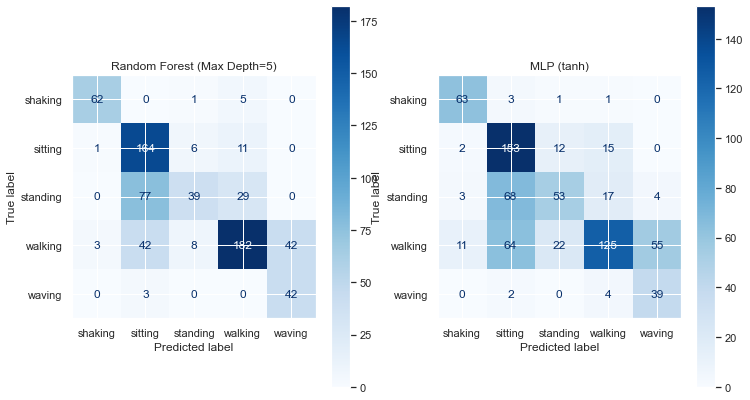

In [55]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(12,7))
plot_confusion_matrix(classifiers[7], x_test, y_test, cmap=plt.cm.Blues, ax=axes[0])
plot_confusion_matrix(classifiers[11], x_test, y_test, cmap=plt.cm.Blues, ax=axes[1])
axes[0].set_title(clf_names[7])
axes[1].set_title(clf_names[11])
plt.show()